![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Regularized Wasserstein Barycenters using Mosek and the exponential cone

In a [previous notebook related to Wasserstein distances](https://nbviewer.jupyter.org/github/MOSEK/Tutorials/blob/master/wasserstein/wasserstein-bary.ipynb) we defined the linear optimization problem of computing the Wasserstein barycenter of a set of discrete measures. Here we solve an entropy-regularized variant of the same problem and to demonstrate the exponential cone capabilities of MOSEK. We also use this problem to compare Fusion and CVXPY.

As a reminder, the $p$-th order Wasserstein distance $W_p(\mu,\upsilon)$ between discrete probability distributions $\mu,\upsilon$ is the objective value of the following problem:
<br>
<br>
$$ \mbox{minimize} \quad \sum_{i=1}\sum_{j=1} D(X_i,Y_j)^p\pi_{ij}$$
<br>
$$ \mbox{st.} \quad \sum_{j=1} \pi_{ij} = \mu_i , \quad i = 1,2,..n $$
<br>
$$ \quad \sum_{i=1} \pi_{ij} = \upsilon_j, \quad j = 1,2,..m $$
<br>
$$ \pi_{ij} \geq 0, \quad \forall_{i,j}$$
<br>
where $D(X_i,Y_j)$ is the distance function.
<br>

## Wasserstein Barycenter with regularization

The entropy regularized barycenter problem with $p=2$ is:
<br>
$$ \mbox{minimize} \quad \frac1N \sum_{i,j,k}^{N} D(X_i,Y_j)^2\pi_{ij}^k + \frac1\lambda\sum_{i,j,k} \pi_{ij}^k\log(\pi_{ij}^k)$$
<br>
$$\mbox{st.}  \quad \sum_{j=1} \pi_{ij}^{k} = \mu_i, \quad \forall_{k,i} \quad (1)$$
<br>
$$ \quad \sum_{i=1} \pi_{ij}^{k} = \upsilon_j^{k}, \quad \forall_{k,j} \quad (2) $$
<br>
$$ \pi_{ij}^{k} \geq 0 \quad \forall_{k,i,j}$$
<br>
where $D(X_i,Y_j)$ is the euclidian distance between pixels, $\lambda = median(D(X_i,Y_j))$ and $N$ is the number of samples.

Without the entropy term the problem is just the linear problem of computing a distribution $\mu$ minimizing the sum of distances to $\upsilon_i$, as studied in our other notebook. Entropy regularization was suggested to us by Stefano Gualandi and appears for example in the paper by Cuturi and Doucet http://proceedings.mlr.press/v32/cuturi14.pdf. This paper contains also more details about the choice of $\lambda$. Also more detailed information about LP aproach to Wasserstein metric can be found in [Stefano Gualandi's blogpost](http://stegua.github.io/blog/2018/12/31/wasserstein-distances-an-operations-research-perspective/).

In this problem, Wasserstein Barycenter of Three's are visualized using images with size $28x28$ using $2$ handwriten '3' digits from MNIST database. Computations are carried out by Intel(R) Xeon(R) CPU E5-2687W v4 @ 3.00GHz processor.

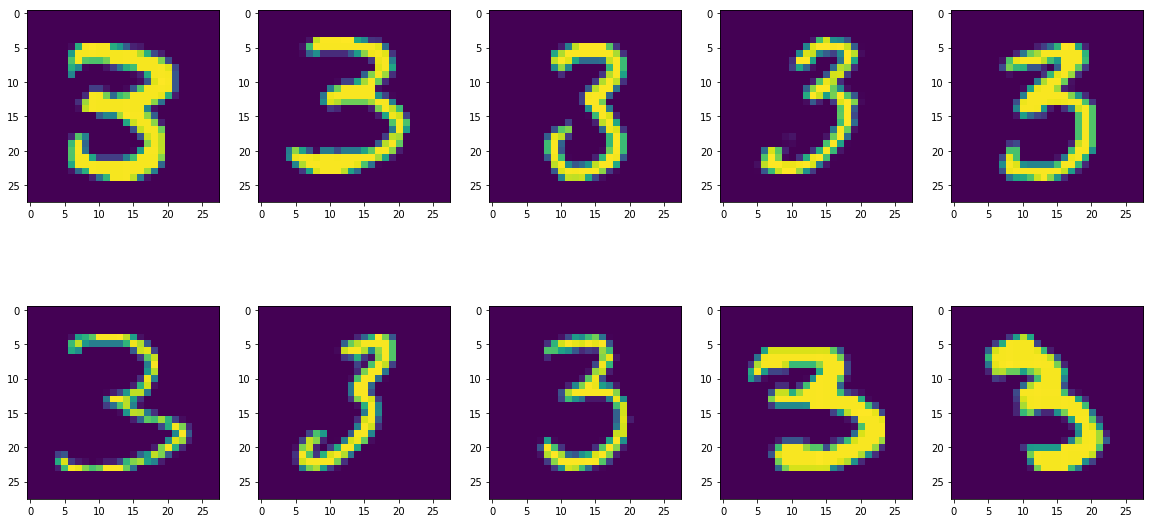

In [1]:
import struct
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

#Define the number of images for the barycenter calculation
n=2
number = 3

#Read the images from the file
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
data = read_idx('train-images.idx3-ubyte')
labels = read_idx('train-labels.idx1-ubyte')
#Select the images
digits = data[labels == number]
train = digits[:n]

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(digits[np.random.randint(0,digits.shape[0])])

## Regularized Barycenters using Mosek Fusion

In [2]:
from mosek.fusion import *
import time
import sys

class Wasserstein_Fusion:
    
    def __init__(self):
        self.time = 0.0
        self.M = Model('Wasserstein')
        self.result = None
    
    
    def single_pmf(self, data = None, img=False):
        
        ''' Takes a image or array of images and extracts the probabilty mass function'''
        
        if not img:
            v=[]
            for image in data:
                arr = np.asarray(image).ravel(order='K')
                v.append(arr/np.sum(arr))
        else:
            v = np.asarray(data).ravel(order='K')
            v = v/np.sum(v)
        return v
    
    def ms_distance(self, m ,n, constant=False):
        
        ''' Squared Euclidean distance calculation between the pixels '''
        
        if constant:
            d = np.ones((m,m))
        else:
            d = np.empty((m,m))
            coor = []
            for i in range(n):
                for j in range(n):
                    coor.append(np.array([i,j]))
            for i in range(m):
                for j in range(m):
                    d[i][j] = np.linalg.norm(coor[i]-coor[j])**2
        return d
    
    def Wasserstein_Distance(self, bc ,data, img = False):
        
        ''' Calculation of wasserstein distance between a barycenter and an image by solving the minimization problem '''
    
        v = np.array(self.single_pmf(data, img))
        n = v.shape[0]
        d = self.ms_distance(n,data.shape[1])
        with Model('Wasserstein') as M:
            #Add variable
            pi = M.variable('pi',[n,n], Domain.greaterThan(0.0))
            
            #Add constraints
            M.constraint('c1' , Expr.sum(pi,0), Domain.equalsTo(v))
            M.constraint('c2' , Expr.sum(pi,1), Domain.equalsTo(bc))
            
            M.objective('Obj.' , ObjectiveSense.Minimize, Expr.dot(d, pi))
            
            M.solve()
            objective = M.primalObjValue()
            
        return objective
    
    def Wasserstein_BaryCenter(self,data):
        
        M = self.M
        start_time = time.time()
        k = data.shape[0]
        v = np.array(self.single_pmf(data))
        n = v.shape[1]
        d = self.ms_distance(n,data.shape[1])
        
        #Add variables   
        mu = M.variable('Mu', n, Domain.greaterThan(0.0))  
        pi = (M.variable('Pi', [k,n,n] , Domain.greaterThan(0.0)))
                
        #Add constraints    
        
        #Constraint (1)
        M.constraint('B', Expr.sub(Expr.sum(pi,1) , Var.repeat(mu,1,k).transpose()), Domain.equalsTo(0.0))
        #Constraint (2)
        M.constraint('C', Expr.sum(pi,2), Domain.equalsTo(v))
            
        M.objective('Obj' , ObjectiveSense.Minimize, Expr.sum(Expr.mul(Expr.mul(Expr.reshape(pi.asExpr(), k, n*n) , d.ravel()), 1/k)))
        
        M.setLogHandler(sys.stdout)
        M.solve()
        self.result = mu.level()
        M.selectedSolution(SolutionType.Interior)
        self.objective = M.primalObjValue()
        self.time = time.time() - start_time
        
        return mu.level()
    
    def Wasserstein_regBaryCenter(self,data, _lambda = None, relgap = None):
        
        M = self.M
        start_time = time.time()
        k = data.shape[0]
        v = np.array(self.single_pmf(data))
        n = v.shape[1]
        d = self.ms_distance(n,data.shape[1])
        
        if not _lambda:
            _lambda = 60/np.median(d.ravel())
        
        
        #Add variables   
        mu = M.variable('Mu', n, Domain.greaterThan(0.0))  
        pi = (M.variable('Pi', [k,n,n] , Domain.greaterThan(0.0)))
        z = M.variable('z', [k,n*n]) #Artificial variable 
        
        #Add constraints
        #Intermediate conic constraints in form z <= -pi log(pi) 
        for i in range(1,k+1):
            M.constraint(Expr.hstack(Expr.constTerm(n*n, 1.0),
                                     Expr.reshape(pi.asExpr(), k*n*n).slice(0+(i-1)*n*n, n*n*i),
                                     Expr.reshape(z.asExpr(), k*n*n).slice(0+(i-1)*n*n, n*n*i)),
                                     Domain.inPExpCone())
    
        #Constraint (1)
        M.constraint('B', Expr.sub(Expr.sum(pi,1) , Var.repeat(mu,1,k).transpose()), Domain.equalsTo(0.0))
        #Constraint (2)
        M.constraint('C', Expr.sum(pi,2), Domain.equalsTo(v))
        
            
        M.objective('Obj' , ObjectiveSense.Minimize, Expr.sum(Expr.mul(Expr.add(Expr.mul(Expr.reshape(pi.asExpr(), k, n*n), d.ravel()),Expr.mul(Expr.sum(z,1),-1/_lambda)), 1/k)))
        
        #relgap is set in case of approximation
        if relgap:
            M.setSolverParam("intpntCoTolRelGap", relgap)
        
        M.setLogHandler(sys.stdout)
        M.solve()
        self.result = mu.level()
        self.objective = M.primalObjValue()
        
        self.time = time.time() - start_time
        
        return self.result
        
        
        
    def reset(self):
        self.M = Model('Wasserstein')
    

In [3]:
fusion_model = Wasserstein_Fusion()
f_bc = fusion_model.Wasserstein_regBaryCenter(train)
print('\nTime Spent to solve problem with Fusion: \n {0}'.format(fusion_model.time))
print('Time Spent in solver: \n {0}'.format(fusion_model.M.getSolverDoubleInfo("optimizerTime")))
print('Objective: \n {0}'.format(fusion_model.objective))

Problem
  Name                   : Wasserstein     
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3691072         
  Cones                  : 1229312         
  Scalar variables       : 6147345         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.79            
Lin. dep.  - number                 : 1               
Presolve terminated. Time: 4.88    
Problem
  Name                   : Wasserstein     
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

65  1.1e-09  1.0e-12  4.6e-14  1.00e+00   -2.453742837e+01  -2.453742939e+01  1.8e-15  506.36
66  1.3e-09  1.0e-12  4.6e-14  1.00e+00   -2.453742837e+01  -2.453742939e+01  1.8e-15  519.57
67  1.2e-09  1.0e-12  4.6e-14  1.00e+00   -2.453742837e+01  -2.453742939e+01  1.8e-15  531.70
68  1.2e-09  1.0e-12  4.6e-14  1.00e+00   -2.453742837e+01  -2.453742939e+01  1.8e-15  544.16
Optimizer terminated. Time: 558.63  


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -2.4537428373e+01   nrm: 1e+00    Viol.  con: 1e-07    var: 0e+00    cones: 2e-12  
  Dual.    obj: -2.4537429385e+01   nrm: 8e+02    Viol.  con: 0e+00    var: 2e-11    cones: 0e+00  

Time Spent to solve problem with Fusion: 
 592.5434217453003
Time Spent in solver: 
 558.629515171051
Objective: 
 -24.53742837253434


In [4]:
nonReg_model = Wasserstein_Fusion()
nonReg = nonReg_model.Wasserstein_BaryCenter(train)
print('\nTime Spent to solve non-regularized problem with Fusion: \n {0}'.format(nonReg_model.time))
print('Time Spent in solver: \n {0}'.format(nonReg_model.M.getSolverDoubleInfo("optimizerTime")))
print('The average Wasserstein distance between digits and the barycenter: \n {0}'.format(nonReg_model.objective))

Problem
  Name                   : Wasserstein     
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 3136            
  Cones                  : 0               
  Scalar variables       : 1230097         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - number                 : 1               
Presolve terminated. Time: 0.96    
Problem
  Name                   : Wasserstein     
  Objective sense        : min             
  Type                   : LO (linear optimization 

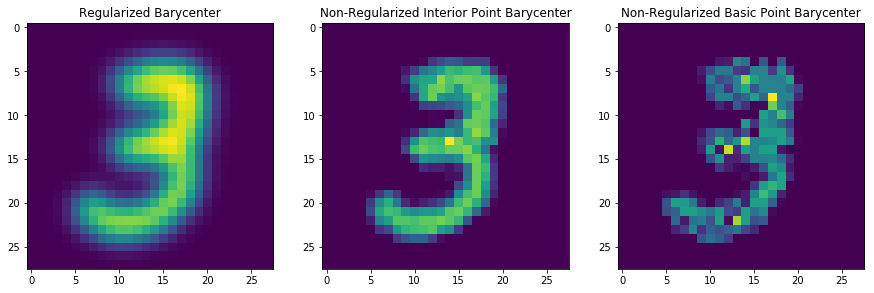

In [5]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(np.reshape(f_bc,(28,28)))
plt.title('Regularized Barycenter')
plt.subplot(1,3,2)
plt.imshow(np.reshape(nonReg, (28,28)))
plt.title('Non-Regularized Interior Point Barycenter')
plt.imshow(np.reshape(nonReg, (28,28)))
plt.subplot(1,3,3)
plt.title('Non-Regularized Basic Point Barycenter')
plt.imshow(np.reshape(nonReg_model.result, (28,28)))
plt.show()

$\quad$ The interiror point solution is different than the basic solution, however this is just a coincidence. The interior point solution gives the convex combination of the extreme points if there is infinetly many optimal solutions but this is not always the case in this problem.

$\quad $ Solving the problem even for just 2 images takes a long time. However, when the output of the iterations are investigated the solver is spending most of the time in earning very little improvements. Since the regularization term is an artificial addition to the problem, it is sensible to test if the approximation with a little loss of accuracy effects the values and images significantly or not, by using "intpntCoTolRelGap" parameter. This parameter controls the relative gap termination tolerance of the conic optimizer.
In the next problem the parameter is increased from 1.0e-7 to 1.0e-3 in order to terminate Mosek with a little bit less accuracy

## Obtaining approximate values

In [6]:
fusion_model2 = Wasserstein_Fusion()
f_bc2 = fusion_model2.Wasserstein_regBaryCenter(train, relgap = "1.0e-3")
print('\nTime Spent to solve problem with Fusion: \n {0}'.format(fusion_model2.time))
print('Time Spent in solver: \n {0}'.format(fusion_model2.M.getSolverDoubleInfo("optimizerTime")))
print('Objective: \n {0}'.format(fusion_model2.objective))

Problem
  Name                   : Wasserstein     
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3691072         
  Cones                  : 1229312         
  Scalar variables       : 6147345         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.75            
Lin. dep.  - number                 : 1               
Presolve terminated. Time: 4.73    
Problem
  Name                   : Wasserstein     
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

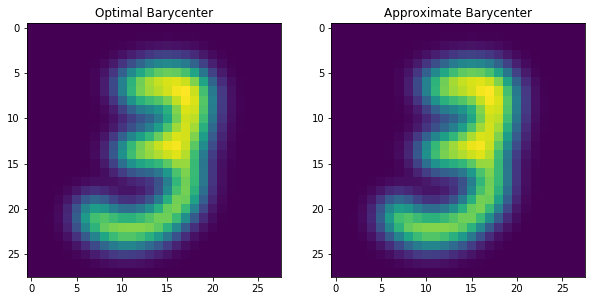

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
fus_bc = np.reshape(f_bc,(28,28))
plt.imshow(fus_bc)
plt.title('Optimal Barycenter')
plt.subplot(1,2,2)
fus_bc2 = np.reshape(f_bc,(28,28))
plt.imshow(fus_bc)
plt.title('Approximate Barycenter')
plt.show()

,count,mean,std,min,25%,50%,75%,max
Stats,784.0,-2.565828e-09,8.372986e-09,-2.593707e-08,-8.399538e-09,-3.616124e-09,-4.976524e-10,2.277483e-08


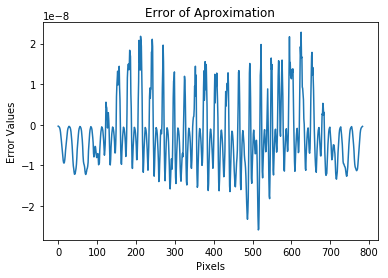

In [8]:
error = pd.Series(f_bc - f_bc2)
plt.plot(error)
plt.title('Error of Aproximation')
plt.xlabel("Pixels")
plt.ylabel('Error Values')
pd.DataFrame(error.describe(), columns=['Stats']).transpose()

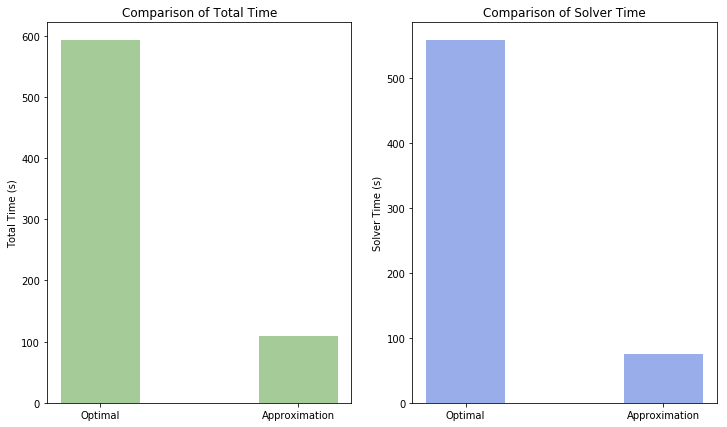

In [9]:
plt.figure(figsize=(12,7))

total_t = [fusion_model.time, fusion_model2.time]
solver_t = [fusion_model.M.getSolverDoubleInfo("optimizerTime"), fusion_model2.M.getSolverDoubleInfo("optimizerTime")]
#Total time plot
plt.subplot(1,2,1)
plt.bar(['Optimal', 'Approximation'], height= total_t,
        width=0.4, color=(0.3, 0.6, 0.2, 0.5))
plt.ylabel("Total Time (s)")
plt.title("Comparison of Total Time")

#Solver time plot
plt.subplot(1,2,2)
plt.bar(['Optimal', 'Approximation'], height=solver_t,
        width=0.4, color=(0.5, 0.6, 0.9, 0.8))
plt.ylabel("Solver Time (s)")
plt.title("Comparison of Solver Time")
plt.show()

$\quad$The two barycenter images that obtained from the optimal solution and approximate solution seem almost identical to each other. In addition statistical description of values of the error between them is presented above with a plot. The mean and the even extreme values are small and indicates that the reduction of time obtained by approximation totally compensates the error.

### Modeling the same problem with CVXPY

In [10]:
import cvxpy as cp
import time
class Wasserstein_CVXPY:
    
    def __init__(self):
        self.time = 0.0
        self.result = None
        self.prob = None

    def single_pmf(self, data = None, img=False):
        
        ''' Takes a image or array of images and extracts the probabilty mass function'''
        
        if not img:
            v=[]
            for image in data:
                arr = np.asarray(image).ravel(order='K')
                v.append(arr/np.sum(arr))
        else:
            v = np.asarray(data).ravel(order='K')
            v = v/np.sum(v)
        return v
    
    def ms_distance(self, m ,n, constant=False):
        
        ''' Squared Euclidean distance calculation between the pixels '''
        
        if constant:
            d = np.ones((m,m))
        else:
            d = np.empty((m,m))
            coor = []
            for i in range(n):
                for j in range(n):
                    coor.append(np.array([i,j]))
            for i in range(m):
                for j in range(m):
                    d[i][j] = np.linalg.norm(coor[i]-coor[j])**2
        return d
    
    def Wasserstein_Distance(self, bc ,data, img = False):
        
        ''' Calculation of wasserstein distance between a barycenter and an image by solving 
            the minimization problem '''
    
        v = np.array(self.single_pmf(data, img))
        n = v.shape[0]
        d = self.ms_distance(n,data.shape[1])
        
        pi = cp.Variable((n,n), nonneg=True)
        obj = cp.Minimize((np.ones(n).T @ cp.multiply(d,pi) @ np.ones(n)))
        
        Cons=[]
        Cons.append((np.ones(n) @ pi).T == bc)
        Cons.append((pi @ np.ones(n)) == v)
        
        prob = cp.Problem(obj, constraints= Cons)
        
        return prob.solve(solver=cp.MOSEK, verbose = True)
        
    def Wasserstein_BaryCenter(self,data):
        
        ''' Calculation of wasserstein barycenter of given images by solving the minimization problem '''
        
        start_time = time.time()
        k = data.shape[0]
        v = np.array(self.single_pmf(data))
        n = v.shape[1]
        d = self.ms_distance(n,data.shape[1])
        
        #Add variables
        pi= []
        t= []
        mu = cp.Variable(n, nonneg = True)
        for i in range(k):
            pi.append(cp.Variable((n,n), nonneg = True))
            t.append(cp.Variable(nonneg = True))
            
        obj = cp.Minimize(np.sum(t)/k)
        
        #Add constraints
        Cons=[]
        for i in range(k):
            Cons.append( t[i] >= np.ones(n).T @  cp.multiply(d,pi[i]) @ np.ones(n) ) #Constraint (1)
            Cons.append( (np.ones(n) @ pi[i]).T == mu)                               #Constraint (2)
            Cons.append( (pi[i] @ np.ones(n)) == v[i])                               #Constraint (3)
            
        self.prob = cp.Problem(obj, constraints= Cons)
        self.result = self.prob.solve(solver=cp.MOSEK,verbose = True)
        self.time = time.time() - start_time
        
        return mu.value
    
    def Wasserstein_regBaryCenter(self,data, _lambda = None, relgap="1.0e-7"):
        
        ''' Calculation of wasserstein barycenter of given 
            images by solving a entropy regularized minimization problem '''
        
        start_time = time.time()
        k = data.shape[0]
        v = np.array(self.single_pmf(data))
        n = v.shape[1]
        d = self.ms_distance(n,data.shape[1])
        
        if not _lambda:
            _lambda = 60/np.median(d.ravel())
        
        #Add variables
        pi= []
        t= []
        mu = cp.Variable(n, nonneg = True)
        for i in range(k):
            pi.append(cp.Variable((n,n), nonneg = True))
            t.append(cp.Variable(nonneg = True))
            
        obj = cp.Minimize((np.sum(t) - (1/_lambda)*np.sum(cp.sum(cp.entr(pi[i])) for i in range(k)))/k)
        
        #Add constraints
        Cons=[]
        for i in range(k):
            Cons.append( t[i] >= (np.ones(n).T @  cp.multiply(d,pi[i]) @ np.ones(n)))#Constraint (1)
            Cons.append( (np.ones(n) @ pi[i]).T == mu)                               #Constraint (2)
            Cons.append( (pi[i] @ np.ones(n)) == v[i])                               #Constraint (3)
            
        self.prob = cp.Problem(obj, constraints= Cons)
        self.result = self.prob.solve(solver=cp.MOSEK,
                                      verbose = True, 
                                      mosek_params = {"MSK_DPAR_INTPNT_CO_TOL_REL_GAP" : relgap })
        self.time = time.time() - start_time
        
        return mu.value
    
    def reset(self):
        self.prob = None
        self.result = None


In [11]:
cvxpy_model = Wasserstein_CVXPY()
cvxpy_result = cvxpy_model.Wasserstein_regBaryCenter(train, relgap = 1.0e-3)
print('\nTime Spent to solve problem with CVXPY: \n {0}'.format(cvxpy_model.time))
print('Time Spent in solver: \n {0}'.format(cvxpy_model.prob.solver_stats.solve_time))
print('The average Wasserstein distance between digits and the barycenter: \n {0}'.format(cvxpy_model.result))

/home/yhk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.




Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4921172         
  Cones                  : 1229312         
  Scalar variables       : 6147346         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.94            
Lin. dep.  - number                 : 1               
Presolve terminated. Time: 5.52    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiz

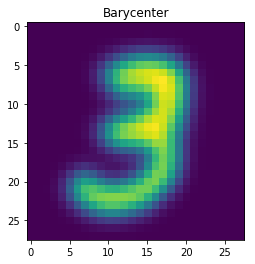

In [12]:
plt.imshow(np.reshape(cvxpy_result.squeeze(), (28,28)))
plt.title('Barycenter')
plt.show()

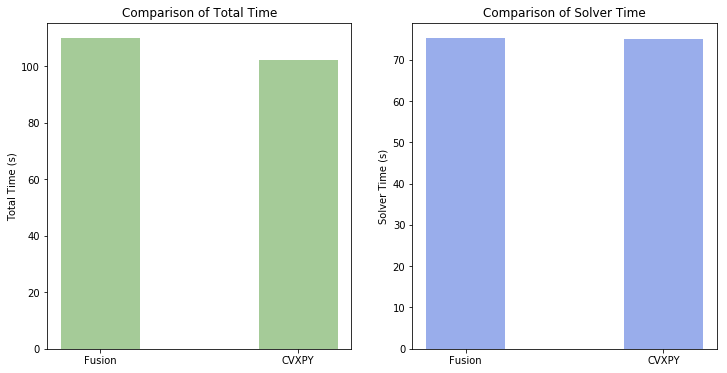

In [13]:
plt.figure(figsize=(12,6))

total_t50 = [fusion_model2.time, cvxpy_model.time]
solver_t50 = [fusion_model2.M.getSolverDoubleInfo("optimizerTime"), cvxpy_model.prob.solver_stats.solve_time]

#Total time plot
plt.subplot(1,2,1)
plt.bar(['Fusion', 'CVXPY'], height= total_t50,
        width=0.4, color=(0.3, 0.6, 0.2, 0.5))
plt.ylabel("Total Time (s)")
plt.title("Comparison of Total Time")

#Solver time plot
plt.subplot(1,2,2)
plt.bar(['Fusion','CVXPY'], height=solver_t50,
        width=0.4, color=(0.5, 0.6, 0.9, 0.8))
plt.ylabel("Solver Time (s)")
plt.title("Comparison of Solver Time")
plt.show()

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 